# Exercise 3

In [1]:
import numpy as np
import cv2
import keyboard
import matplotlib
import matplotlib.pyplot as plt
from util_functions import *

matplotlib.use("TkAgg")

%matplotlib inline

In [2]:
K = camera_intrinsic(1000, (300,200))
K

array([[1000,    0,  300],
       [   0, 1000,  200],
       [   0,    0,    1]])

In [3]:
def R(theta_x,theta_y,theta_z):
    '''
    Angles in radians.

    Returns : Rz @ Ry @ Rx
    '''
    Rx = np.array([[1,0,0],
                   [0,np.cos(theta_x),-np.sin(theta_x)],
                   [0,np.sin(theta_x),np.cos(theta_x)]])
    Ry = np.array([[np.cos(theta_y),0,np.sin(theta_y)],
                   [0,1,0],
                   [-np.sin(theta_y),0,np.cos(theta_y)]])
    Rz = np.array([[np.cos(theta_z),-np.sin(theta_z),0],
                   [np.sin(theta_z),np.cos(theta_z),0],
                   [0,0,1]])
    return Rz @ Ry @ Rx

In [24]:
R1 = np.eye(3)
t1 = np.array([[0,0,0]]).T
R2 = R(0.7,-0.5,0.8)
t2 = np.array([[0.2,2,1]]).T
R2

(3, 1)


array([[ 0.61141766, -0.76384514,  0.20666167],
       [ 0.6295392 ,  0.31131209, -0.71187442],
       [ 0.47942554,  0.56535421,  0.67121217]])

In [5]:
# Alternative way to construct rotation matrix
from scipy.spatial.transform import Rotation
R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
R2

array([[ 0.61141766, -0.76384514,  0.20666167],
       [ 0.6295392 ,  0.31131209, -0.71187442],
       [ 0.47942554,  0.56535421,  0.67121217]])

In [6]:
# Ex 3.1
# Find projections in the 2 cameras

Q = np.array([[1,0.5,4,1]]).T
Q = Pi(Q)   # make Q 3x1 for projectpoints()

q1 = projectpoints(K, R1, t1, Q)    # project Q to image plane of camera 1
q2 = projectpoints(K, R2, t2, Q)    # project Q to image plane of camera 2
print(f'q1: {q1.T}')    # projected point in pixels in camera 1
print(f'q2: {q2.T}')    # projected point in pixels camera 2

q1: [[550. 325.]]
q2: [[582.47256835 185.98985776]]


In [7]:
# Ex 3.2
# Cross product operator

def CrossOp(r):
    '''Returns the cross product operator of r.'''
    if r.shape == (3,1):
        r = r.flatten()
    if r.shape != (3,):
        raise ValueError('r must be a 3x1 vector')
    
    return np.array([[0,-r[2],r[1]],
                     [r[2],0,-r[0]],
                     [-r[1],r[0],0]])

# Check if the above function works
# p1 = np.array([1,2,3]).T
# p2 = np.array([4,5,6]).T
# print(np.cross(p1, p2))
# print(CrossOp(p1) @ p2)


In [8]:
# Ex 3.3
# Compute fundamental matrix

def essential_matrix(R, t):
    '''Returns the essential matrix.'''
    return CrossOp(t) @ R

def fundamental_matrix(K1, R1, t1, K2, R2, t2):
    '''
    Returns the fundamental matrix, assuming camera 1 coordinates are 
    on top of global coordinates.    
    '''
    if R1.shape != (3,3) or R2.shape != (3,3):
        raise ValueError('R1 and R2 must be 3x3 matrices')
    if t1.shape == (3,) or t2.shape == (3,):
        t1 = t1.reshape(-1,1)
        t2 = t2.reshape(-1,1)
    if t1.shape != (3,1) or t2.shape != (3,1):
        raise ValueError('t1 and t2 must be 3x1 matrices')
    if K1.shape != (3,3) or K2.shape != (3,3):
        raise ValueError('K1 and K2 must be 3x3 matrices')
    
    # When the {camera1} and {camera2} are not aligned with {global}
    R_tilde = R2 @ R1.T
    t_tilde = t2 - R_tilde @ t1
    
    E = essential_matrix(R_tilde, t_tilde)
    F = np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)
    return F

# {1} lies on the same axis as the global coordinates as R1 = eye(3)
# Thus, use R1 to compute essential matrix
F = fundamental_matrix(K, R1, t1, K, R2, t2)
print(f"F: {F}")

F: [[ 3.29311881e-07  8.19396327e-07  1.79162592e-03]
 [ 5.15532551e-07 -8.76915984e-07  9.31426656e-05]
 [-1.29882755e-03  1.51951700e-03 -1.10072682e+00]]


In [9]:
# Ex 3.4
# Equation of the epipolar line in camera 2

l2 = F @ PiInv(q1)      # epipolar line of q1 in camera 2
l2/l2[2]*-5.285         # to match the answer

array([[ 8.95627993e-03],
       [ 3.66754562e-04],
       [-5.28500000e+00]])

In [10]:
# Ex 3.5
# Check if q2 is located on the epipolar line l2

print(l2.shape)
print(q1.shape)

PiInv(q2).T @ l2                # should be 0
# Since the dot product is close to 0, the point is on the line.

(3, 1)
(2, 1)


array([[4.4408921e-16]])

In [11]:
# Ex 3.6
# Both camera have local coordinate systems, different from world coordinates.
# Refer to ans for full derivation

# Ex 3.7
# Refer to the ans for full derivation

dict_keys(['im1', 'R1', 't1', 'im2', 'R2', 't2', 'K'])
(3,) (3,)
F: [[-1.50228281e-08 -3.45997421e-07 -3.47606501e-05]
 [-2.06767970e-07  3.96284278e-08 -9.29558240e-04]
 [ 2.61581163e-05  1.12168578e-03  1.17449076e-02]]


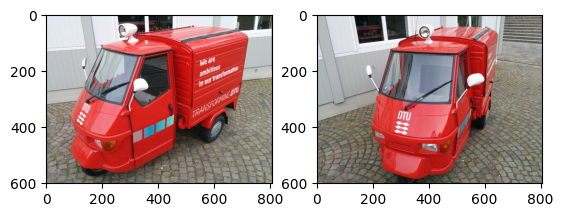

In [12]:
# Ex 3.8
# Compute fundamental matrix between 2 images

data = np.load('media/TwoImageDataCar.npy', allow_pickle=True).item()
print(data.keys())
im1 = data['im1']
im2 = data['im2']
K = data['K']
R1 = data['R1']
t1 = data['t1']
R2 = data['R2']
t2 = data['t2']

print(t1.shape,t2.shape)
F = fundamental_matrix(K, R1, t1, K, R2, t2)
print(f"F: {F}")

plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im2)
plt.show()

In [13]:
# Ex 3.9
# Click on a point, and draw the epipolar line on the other image

def DrawLine(l, shape):
    # Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame

    def in_frame(l_im):
        '''Returns the intersection point of the line with the image frame.'''
        q = np.cross(l.flatten(), l_im) # intersection point
        q = q[:2]/q[2]                  # convert to inhomogeneous
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
    
    # 4 edge lines of the image
    lines = [[1, 0, 0],             # x = 0
             [0, 1, 0],             # y = 0
             [1, 0, 1-shape[1]],    # x = shape[1]
             [0, 1, 1-shape[0]]]    # y = shape[0]
    
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    
    if (len(P)==0):
        print("Line is completely outside image")
    plt.plot(*np.array(P).T)

In [18]:
figure = plt.figure()
ax1 = plt.subplot(1,2,1)
ax1.imshow(im1)
ax1.set_title('Click on a point')
ax2 = plt.subplot(1,2,2)
ax2.imshow(im2)
ax2.set_title('Epipolar line will be drawn here')

# Click on a point in the first image
q = plt.ginput(1)
q = q[0]
ax1.plot(q[0], q[1], 'bx')

l = F @ PiInv(np.array([q]).T)
DrawLine(l, im2.shape)

In [19]:
# Ex 3.10
# Flip images
figure = plt.figure()
ax1 = plt.subplot(1,2,1)
ax1.imshow(im2)
ax1.set_title('Click on a point')
ax2 = plt.subplot(1,2,2)
ax2.imshow(im1)
ax2.set_title('Epipolar line will be drawn here')

# Click on a point in the first image
q = plt.ginput(1)
q = q[0]
ax1.plot(q[0], q[1], 'bx')

l = F @ PiInv(np.array([q]).T)
DrawLine(l, im1.shape)

In [31]:
# Ex 3.11
# Triangulation
def triangulate(q_list,P_list):
    '''
    Triangulate a single 3D point seen by n cameras.

    q_list : nx2x1 list of 2x1 pixel points
    P_list : nx3x4, list of 3x4 camera projection matrices
    '''
    B = []  # 2n x 4 matrix
    for i in range(len(P_list)):
        qi = q_list[i]
        P_i = P_list[i]
        B.append(P_i[2]*qi[0]-P_i[0])
        B.append(P_i[2]*qi[1]-P_i[1])
    B = np.array(B)
    U, S, Vt = np.linalg.svd(B)
    # TODO: why is the 3D point the last column of the matrix V
    # returned by the SVD, normalized to have a last coordinate of 1.
    Q = Vt[-1,:-1]/Vt[-1,-1]
    return Q

# Camera parameters
K = camera_intrinsic(1000, (300,200))
R1 = np.eye(3)
t1 = np.array([[2,3,4]]).T
R2 = R(0.7,-0.5,0.8)
t2 = np.array([[0.2,2,1]]).T

# Arbitrary 3D point
Q = np.array([[1, 0.5, 4]]).T

# Triangulate procedure
q1 = projectpoints(K, R1, t1, Q)    # project Q to image plane of camera 1
q2 = projectpoints(K, R2, t2, Q)    # project Q to image plane of camera 2
P1 = K @ np.hstack((R1,t1))
P2 = K @ np.hstack((R2,t2))
Q = triangulate([q1,q2],[P1,P2])
Q

array([1. , 0.5, 4. ])